# SSABN

## Written by Zhiru Yang

## 0、Import

In [1]:
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from numpy.random import seed
seed(2)
from tensorflow import random
random.set_seed(2)
from tensorflow.keras import Model
from scipy import io as sio
import numpy as np
import os
import swinT
from utils import (
    PlotWhileTraining,
    load_HSI,
    plotEndmembersAndGT,
    plotAbundancesSimple,
    compute_sad)
from tensorflow.keras.layers import (
    Conv2D,
    concatenate,
    LeakyReLU,
    Dense,
    Input,
    Dropout,
    Layer
)
import matplotlib.pyplot as plt

## CPU

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## 1、Loss Function

In [3]:
def SAD(y_true, y_pred):
    A = -tf.keras.losses.cosine_similarity(y_true,y_pred)
    sad = tf.math.acos(A)
    return sad

In [4]:
def array(x):
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        x= sess.run(x)
    return x

## 2、Class Sum ToOne

In [5]:
class SumToOne(Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.params = params
    
    def call(self, x):   
        x = tf.nn.softmax(self.params['scale']*x)
        return x

## 3、Class Encoder

In [6]:
class SCAM_layer(tf.keras.Model):
    def __init__(self, filter_sq):
        super().__init__()
        self.filter_sq = filter_sq
        self.avepool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(filter_sq)
        self.relu = LeakyReLU()
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        b,h,w,c=inputs.shape
        x1=tf.reshape(inputs,(-1,h*w,c))
        dots =tf.einsum('bdi,bdj->bij', x1, x1) * (c**-0.5)
        attn = tf.nn.softmax(dots,axis=-1)
        scale = attn@tf.transpose(x1, perm=[0, 2, 1])
        scale=tf.transpose(scale, perm=[0, 2, 1])
        scale=tf.reshape(scale,(-1,h,w,c))
        return scale

In [7]:
class Encoder(Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer1= swinT.SwinT(depths=[2],num_heads=[5],window_size=4)
        self.hidden_layer2=SCAM_layer(16)
        self.asc=SumToOne(params=self.params)

        
    def call(self, input_patch):
        input_patch1=tf.pad(input_patch,[[0,0],[0,1],[0,1],[0,0]], mode="SYMMETRIC", name=None, constant_values=0)
        b,h,w,c=input_patch.shape
        
        code1=Conv2D(filters=40,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     use_bias=False)(input_patch1) 
        
        code2 = LeakyReLU()(code1) 
        code2= Dropout(0.2)(code2)
        code2=self.hidden_layer1(code2)
        
        code11=Conv2D(40,1,1,padding='same',use_bias=False)(input_patch1)
        code11 = LeakyReLU()(code11) 
        code11 = Dropout(0.2)(code11)
        code11=self.hidden_layer2(code11)
        code11=Conv2D(16,1,1,padding='same',use_bias=False)(code11)
        code11 = LeakyReLU()(code11) 
        code11 = Dropout(0.2)(code11)
        code11=self.hidden_layer2(code11)
        
        code2=concatenate([code11, code2], axis=3)
        
        code2=Conv2D(self.params['num_endmembers'],1,1,use_bias=False)(code2)
        code3=self.asc(code2)
        code3=code3[:,0:h,0:w,:]
        return code3

## 4、Class Decoder


In [8]:
class Decoder(Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.params=params
        self.output_layer= Dense(units=params["data"].array(0).shape[1],
                                 kernel_regularizer=None,
                                 activation='linear',
                                 name="endmembers",
                                 kernel_constraint=tf.keras.constraints.non_neg(),
                                 use_bias=False)
        
    def call(self, code):   
        B, H, W, C = code.shape
        code = tf.reshape(code, [-1, H * W, C])
        recon = self.output_layer(code)
        recon = tf.reshape(recon, [-1, H, W, self.params["data"].array(0).shape[1]])
        return recon
    
    def getEndmembers(self):
        w=self.output_layer.get_weights()[0]
        return w

## 5、Class Autoencoder

In [9]:
class Autoencoder(object):
    def __init__(self, patches,params):
        self.data = params["data"].image
        self.encoder = Encoder(params)
        self.params = params
        self.decoder = Decoder(params)
        self.H=patches.shape[1]
        self.W=patches.shape[2]
        self.model=self.create_model()
        self.model.compile(optimizer=self.params["optimizer"], loss=self.params["loss"])
        
    def create_model(self):
        input_a = Input(shape=(self.H,self.W,self.params["data"].array(0).shape[1],))
        abunds = self.encoder(input_a)
        output = self.decoder(abunds)
        return Model(inputs=input_a, outputs=output)
    def get_endmembers(self):
        endmembers = self.decoder.getEndmembers() 
        return endmembers

    def get_abundances(self):  
        abundances=np.squeeze(self.encoder.predict(np.expand_dims(self.data, 0)))
        return abundances

    def fit(self, patches,n):
        plot_callback = PlotWhileTraining(0,self.params['data'])
        y=self.model.fit(
            x=patches, y=patches, 
            epochs=self.params['epochs'], 
            batch_size=self.params['batch_size'],
            callbacks=[plot_callback],
            verbose=1
        )
        # Plot loss pictures for training epochs
        loss_values = y.history['loss']
        fig = plt.figure()
        rect = fig.patch
        rect.set_facecolor('white')
        plt.plot(range(1, len(loss_values)+1), loss_values, 'b-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        save_path = 'loss_'+self.params["dataset"]+'.png'
        fig.savefig(save_path)
        plt.show()
   
        return y

## 6、Load data and set hyperparameters

In [10]:
datasetnames = {
    "Sy_data":"Sy",
    "Samson": "Samson",
    "Urban":"Urban4",
}
dataset= "Urban"
# Hyperparameters
hsi = load_HSI(
    "./Datasets/" + datasetnames[dataset] + ".mat"
)

# Hyperparameters
batch_size = 2
heads=5
learning_rate = 0.006
epochs=50
scale =1
loss=SAD
opt= tf.optimizers.RMSprop(learning_rate=learning_rate, decay=0.000)

## 7、Train the autoencoder and run the example

Train on 20 samples
Epoch 1/50
20/20 [==============================] - 40s 2s/sample - loss: 0.7533
Epoch 2/50
20/20 [==============================] - 42s 2s/sample - loss: 0.3262
Epoch 3/50
20/20 [==============================] - 41s 2s/sample - loss: 0.3032
Epoch 4/50
20/20 [==============================] - 42s 2s/sample - loss: 0.3027
Epoch 5/50
20/20 [==============================] - 42s 2s/sample - loss: 0.3273
Epoch 6/50
20/20 [==============================] - 42s 2s/sample - loss: 0.2994
Epoch 7/50
20/20 [==============================] - 42s 2s/sample - loss: 0.2976
Epoch 8/50
20/20 [==============================] - 43s 2s/sample - loss: 0.3026
Epoch 9/50
20/20 [==============================] - 41s 2s/sample - loss: 0.2195
Epoch 10/50
20/20 [==============================] - 41s 2s/sample - loss: 0.2056
Epoch 11/50
20/20 [==============================] - 41s 2s/sample - loss: 0.1965
Epoch 12/50
20/20 [==============================] - 41s 2s/sample - loss: 0.1933
Epoch

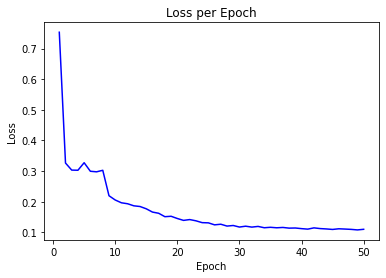

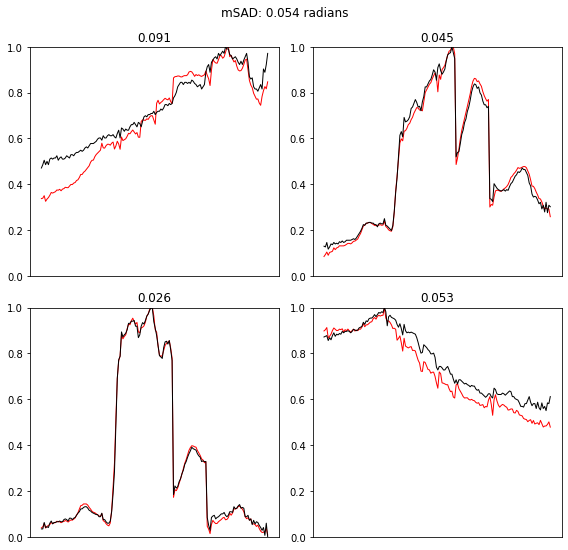

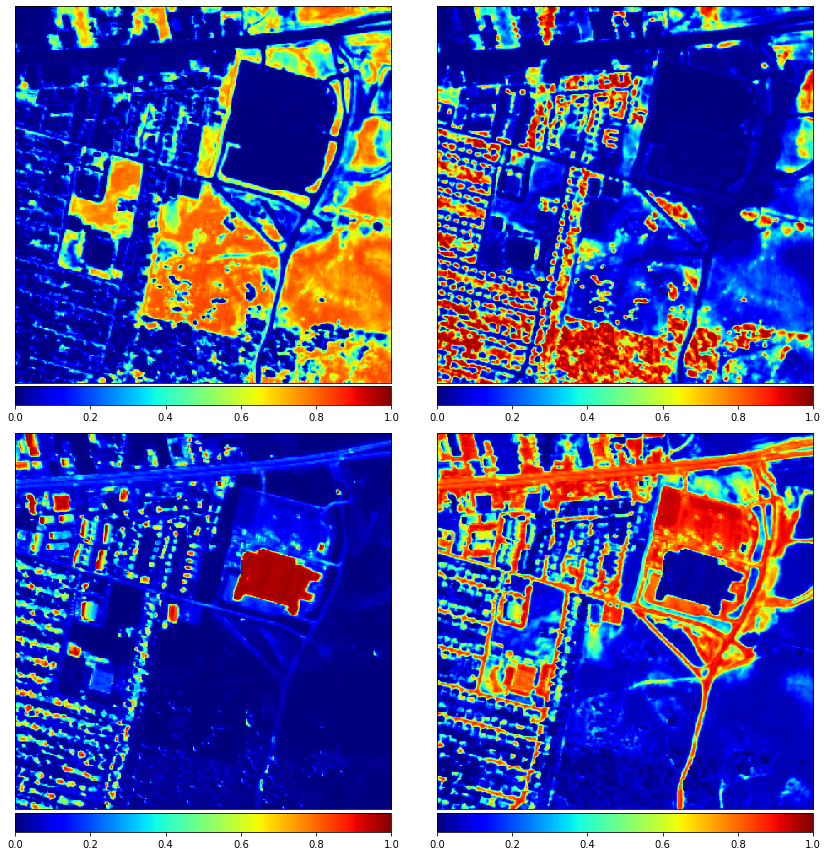

cpu_time:2074.6004548072815


In [11]:
num_runs =1
results_folder = '\Results'
method_name = '0_SSABN'

for ds in [heads]:
    results_folder = './Results'
    params = {
    "dataset":dataset,
    "heads":ds,
    "scale":scale,
    "batch_size": batch_size,
    "data": hsi,
    "epochs": epochs,
    "n_bands": hsi.bands,
    "GT": hsi.gt,
    "lr": learning_rate,
    "optimizer": opt,
    "loss": loss,
    "num_endmembers":hsi.p
    }
    save_folder = results_folder+'/'+method_name+'/'+dataset
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    for run in range(1,num_runs+1):
        training_data = list()
        for i in range(0, 20):
            training_data.append(hsi.image[np.newaxis, :])
        training_data = np.concatenate(training_data, axis=0)
        save_folder = results_folder+'/'+method_name+'/'+dataset
        save_name = dataset+'_run'+str(run)+'.mat'
        save_path = save_folder+'/'+save_name
        start = time.time()
        autoencoder = Autoencoder(training_data,params)
        autoencoder.fit(training_data,epochs)
        endmembers = autoencoder.get_endmembers()
        abundances = autoencoder.get_abundances() 
        end = time.time()
        plotEndmembersAndGT(endmembers, hsi.gt)
        plotAbundancesSimple(abundances,'abundance_'+dataset)
        sio.savemat(save_path,{'A':endmembers,'S':abundances})
        cpu_time = end - start
        print('cpu_time:{}'.format(cpu_time))
        del autoencoder